## Ultimate Challenge
Solution provided by: Eugene Wen

### I. Exploratory Data Analysis

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats

In [2]:
# Load json file
Data = pd.read_json("logins.json")

In [3]:
Data.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
# Create and initialize the count column
Data['Count'] = 1

In [5]:
# Set timestamp as index
Data = Data.set_index('login_time')

Plot the 15-min aggregated counts on login records: 

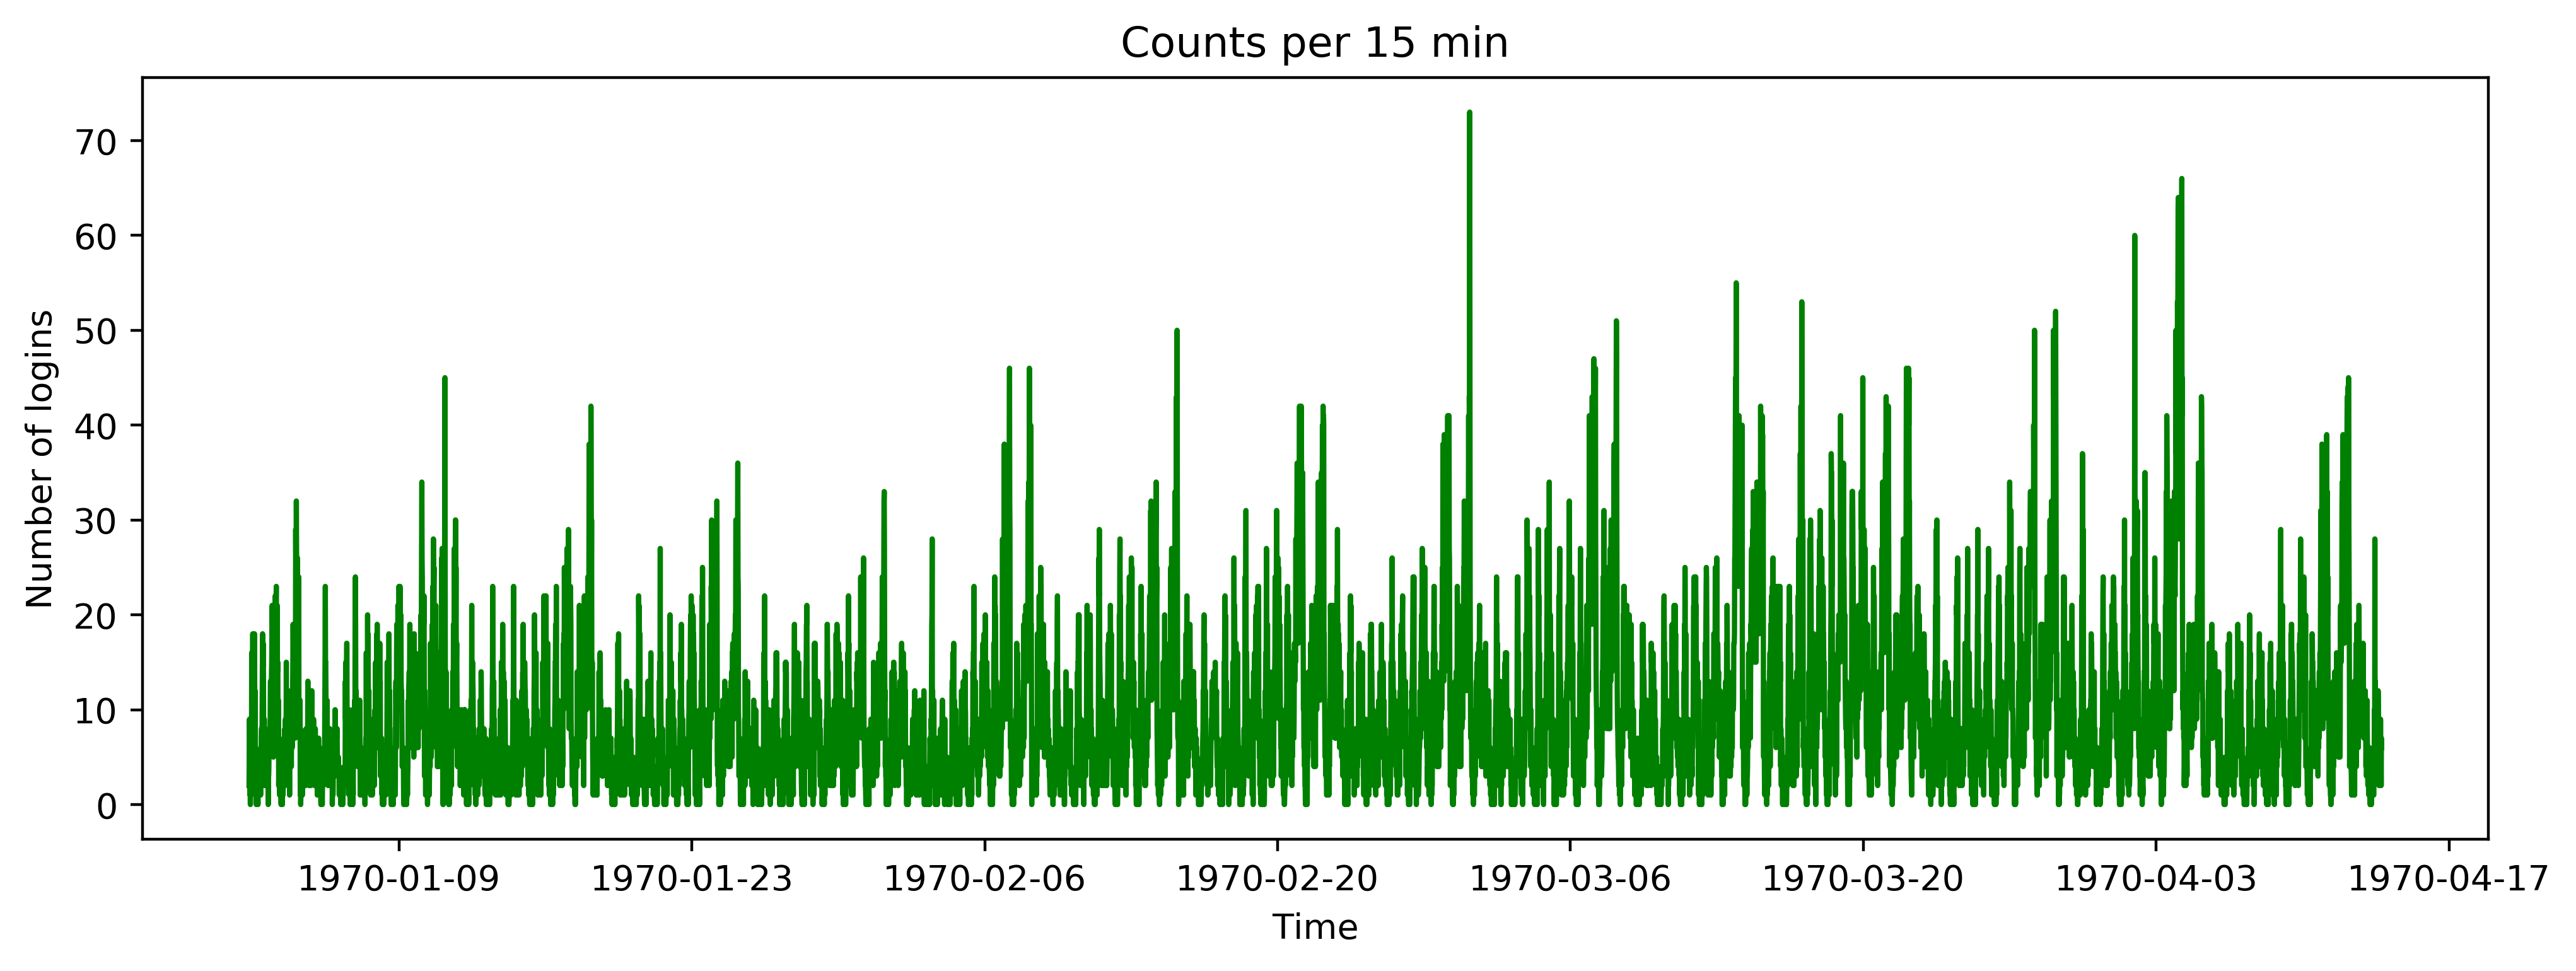

In [6]:
fig = plt.figure(figsize=(12,4), dpi=400)
axes = fig.add_subplot(111, title="Counts per 15 min", xlabel= "Time", ylabel= "Number of logins")
axes.plot(Data.resample('15Min').count(), color = 'g')
plt.show()

It seems that there are cyclic patterns. Try to sample by calendar days to see whether the pattern becomes obvious.

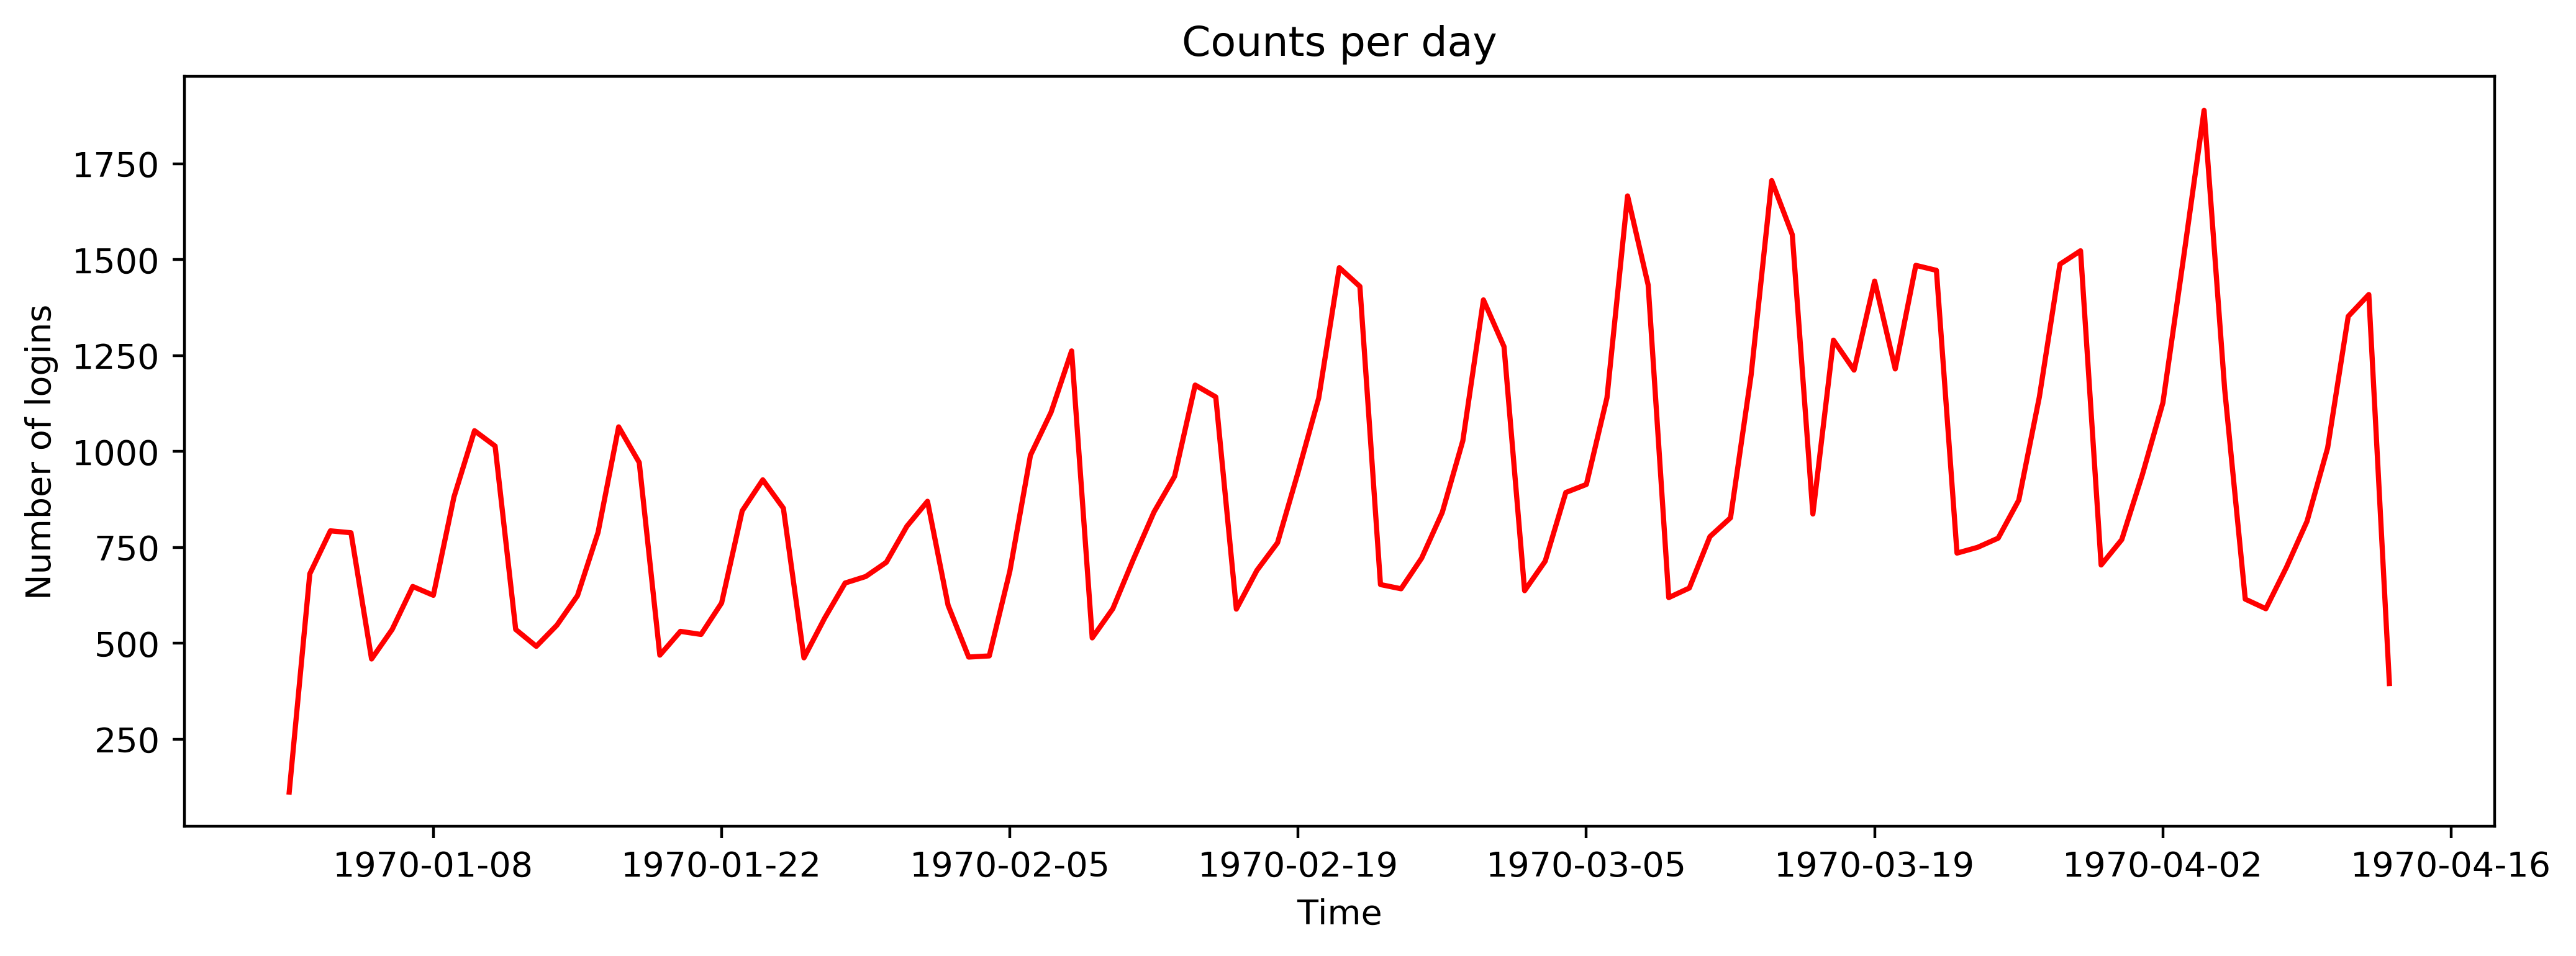

In [7]:
fig = plt.figure(figsize=(12,4), dpi=400)
axes = fig.add_subplot(111, title="Counts per day", xlabel= "Time", ylabel= "Number of logins")
axes.plot(Data.resample('D').count(), color = 'r')
plt.show()

It would be useful to investigate the weekdays mean login frequencies. The cyclic pattern seems to be weekly. A rough guess is that weekend may have higher demand than usual.

In [8]:
# Count by weekdays
Data_15min = Data.resample('15Min').count().reset_index()
Data_15min['weekday'] = Data_15min['login_time'].dt.dayofweek

wk_fq = Data_15min.groupby('weekday').sum().reset_index()
wk_fq['Weekday'] = ['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday']
wk_fq[['Weekday', 'Count']]

,Weekday,Count
0,Monday,8823
1,Tuesday,9268
2,Wednesday,10339
3,Thursday,11960
4,Friday,15208
5,Saturday,19377
6,Sunday,18167


This confirmed our guess that weekend demand is quite high comparing to business days as the cycle pattern shows.

### II. Experiment and metric design

1. The metric I would use is the login frequency after toll reimbursement program starts. Eventually, the number of logins is somehow reflecting the revenue generation. If more people are requesting service, more revenue would be expected. We should continue logging the time of each login and comparing to the historical data to see the activity changes. 

2. I would choose two normal weeks to apply toll reimbursement and compare to the non-reimbursement weeks' activity. It could be run two-week on and two-week off the program for 2 months. The 15-min login data could be used for comparison, aligned by hour or weekday to see whether at certain time period or certain weekday the activities have significant increase after toll reimbursement. It could be the case that at all time the activities increase. Using t-test or rank test would be OK to test the difference statistically.

It must be noticed that the increased login should reflect revenue increase. If the overall revenue increase is not observed, the high activity may be cause by some other reason such as app bug that constantly log users off. Also, even if the revenue increase is observed, the toll reimbursement cost may not be fully covered and consequently loses profit. This should be closely monitored to ensure there are sufficient revenue generated by applying toll reimbursement.


### III. Predictive Modeling 

In this section, we attempt to build a predictive model to find the most effective features to the behavior of passengers. Specifically, we want to identify whether a customer is going to drop the service (churn) or continue to be a passenger (retained) in a span of 6 months.

In [9]:
# Load the data
import json
with open('ultimate_data_challenge.json', 'r') as datafile:
    data = json.load(datafile)
predictDF = pd.DataFrame(data)

In [10]:
predictDF.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [11]:
predictDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [12]:
# Correct time variable format
predictDF['last_trip_date'] = pd.to_datetime(predictDF.last_trip_date, format='%Y-%m-%d')
predictDF['signup_date'] = pd.to_datetime(predictDF.signup_date, format='%Y-%m-%d')

# Create new variable: account history, i.e. how long is the user in the system
predictDF['days_in_system'] = (predictDF.last_trip_date - predictDF.signup_date).map(lambda x: x.days)

In [13]:
# create target value: retained
predictDF4 = predictDF
latest_trip = (pd.to_datetime(predictDF.last_trip_date)).max()
predictDF['retained'] = pd.to_datetime(predictDF4.last_trip_date) > (latest_trip - pd.Timedelta('31 day')) 

Looking at the count values it is easy to identify those features that are missing values. Having 50,000 rows we can afford dropping some of them. From the above table we will drop average ratings with missing values.

It is required to check other categorical features for missing values:

In [14]:
# Check each categorical variable
predictDF.city.value_counts()
#predictDF4.city.isnull().value_counts()

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

There are no missing values for 'city' feature.

Checking 'phone':

In [15]:
predictDF.phone.value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

In [16]:
predictDF.groupby(['retained']).describe()

avg_dist                                                     \
            count      mean       std  min   25%   50%   75%     max   
retained                                                               
False     31196.0  6.207939  6.238675  0.0  2.32  4.03  7.80  129.89   
True      18804.0  5.114788  4.615175  0.0  2.56  3.73  5.89  160.96   

         avg_rating_by_driver            ...   trips_in_first_30_days         \
                        count      mean  ...                      75%    max   
retained                                 ...                                   
False                 31031.0  4.787464  ...                      2.0   73.0   
True                  18768.0  4.762772  ...                      4.0  125.0   

         weekday_pct                                                       
               count       mean        std  min   25%   50%    75%    max  
retained                                                                   
False        31196.0  60.647032  40.982688  0.0  16.7  69.6  100.0  100.0  
True         18804.0  61.389034  29.487584  0.0  44.4  64.3   84.6  100.0  

[2 rows x 64 columns]

In [17]:
predictDF.retained.value_counts()

False    31196
True     18804
Name: retained, dtype: int64

In [18]:
retained_frac = 18804/50000
retained_frac

0.37608

37.6% users were retained!

# Prediction model and feature importance

In this excercise I am using XGBoost classifier to create a predictive model and also analyze variable importance.

In [19]:
from xgboost import XGBClassifier, plot_importance

In [20]:
# First we hot encode the phone predictor

IsAndroidSeries = predictDF.phone.apply(lambda x: (1 if x == 'Android' else 0) )
predictDF4.loc[:, 'IsAndroid'] = IsAndroidSeries

In [21]:
# Hot encode the city predictor. 
predictDF4.loc[:, 'IsWinterfell'] = predictDF4.city.apply(lambda x: 1 if x == 'Winterfell' else 0)
predictDF4.loc[:, 'IsAstapor'] = predictDF4.city.apply(lambda x: 1 if x == 'Astapor' else 0)

In [22]:
# copy the newly created columns above
retainedDF = predictDF4[predictDF4.retained][['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver',  'avg_surge', 'surge_pct', 'weekday_pct', 'IsAstapor', 'IsWinterfell', 'IsAndroid', 'retained']]
nretainedDF = predictDF4[~predictDF4.retained][['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver',  'avg_surge', 'surge_pct', 'weekday_pct', 'IsAstapor', 'IsWinterfell', 'IsAndroid', 'retained']].head(len(retainedDF))
combinedDF = retainedDF.append(nretainedDF)

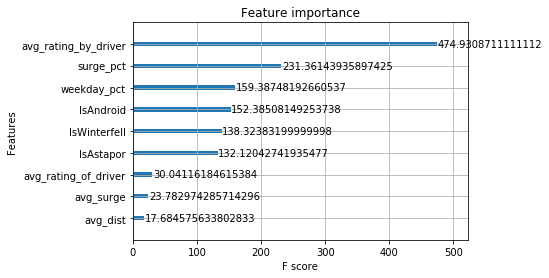

In [23]:
# Build XGbooster classifier
xgb = XGBClassifier()
xgb.fit(predictDF4[['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver',  'avg_surge', 'surge_pct', 'weekday_pct', 'IsAstapor', 'IsWinterfell', 'IsAndroid']], predictDF4.retained.values)
plot_importance(xgb, importance_type='gain')

In [24]:
from sklearn.metrics import roc_auc_score
roc_auc_score(xgb.predict(predictDF4[['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver',  'avg_surge', 'surge_pct', 'weekday_pct', 'IsAstapor', 'IsWinterfell', 'IsAndroid']]), 
              predictDF4.retained.values)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.7636401453792984

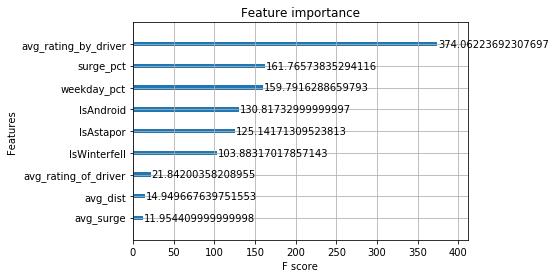

In [25]:
xgb.fit(combinedDF.drop('retained', axis=1), combinedDF.retained.values)
plot_importance(xgb, importance_type='gain')

In [26]:
roc_auc_score(xgb.predict(combinedDF.drop('retained', axis=1)), combinedDF.retained.values)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.7626866104055519

### Results and recommendations

Using XGBoost we found the most important factors predicting the retained customers are:
 - the average rating by driver
 - the phone type of the person
 - average surge price
 - percent of weekday trips
 - city where a passenger lives